Code used in computing correlations between the raw variables, and consolidating those variables that correlate highly and significantly (section 'Data Preparation' in thesis).

In [1]:
%matplotlib inline
import os, collections
import numpy as np
import pandas as pd
import scipy.spatial, scipy.stats
import permute.core
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [2]:
Recording = collections.namedtuple('Recording',['fn','df']) # filename and dataframe 
def load_data(dirpath):
    dfs = []
    for root, _, filenames in os.walk(dirpath):
        for filename in filenames:
            filepath = os.path.join(root,filename)
            nxt = pd.read_csv(filepath,index_col=0,compression='gzip')
            dfs.append(Recording(filename,nxt))
    return dfs

In [3]:
# load all files from data_clean directory into a list of DataFrames
data = load_data('../data_clean')

In [4]:
# create a counter of the lengths of the files in the data (some are less than half an hour long)
lens = collections.Counter(len(rec.df) for rec in data)
# get just the files that are the longest (half an hour long)
data_long = [rec for rec in data if len(rec.df)==max(lens)]
# print the amount of data that remains
len(data_long)/len(data)

0.9607843137254902

In [5]:
lens

Counter({27002: 11, 36742: 1, 45001: 294})

In [6]:
def square_pdist(*args,**kwargs):
    return scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(*args,**kwargs))

def rp_annot(r,p):
    rs = np.vectorize(lambda x: '{:.2f}'.format(x).rstrip('0').rstrip('.'))(r)
    ps = np.vectorize(lambda x: '^' if x >= 0.05 else '')(p)
    return np.core.defchararray.add(rs,ps)

def rp_plot(data,ax):
    # concatenate data, remove empty rows and transpose data
    df = pd.concat(rec.df for rec in data)
    dfnT = df.dropna().T
    # correlations
    r = df.corr()
    # p-values based on simulation
    #p = square_pdist(dfnT,lambda x,y: permute.core.corr(x,y,reps=100)[3])
    # p-values based on incomplete beta integral
    p = square_pdist(dfnT,lambda x,y: scipy.stats.pearsonr(x,y)[1])
    # create triangle mask for matrix data
    mask = np.zeros_like(r,dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plot = sns.heatmap(r, vmin=-1, vmax=1, cmap='viridis', annot=rp_annot(r,p), fmt='', annot_kws={'size':8}, linewidths=.5, square=True, mask=mask, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_label('correlation')
    return r,p,plot

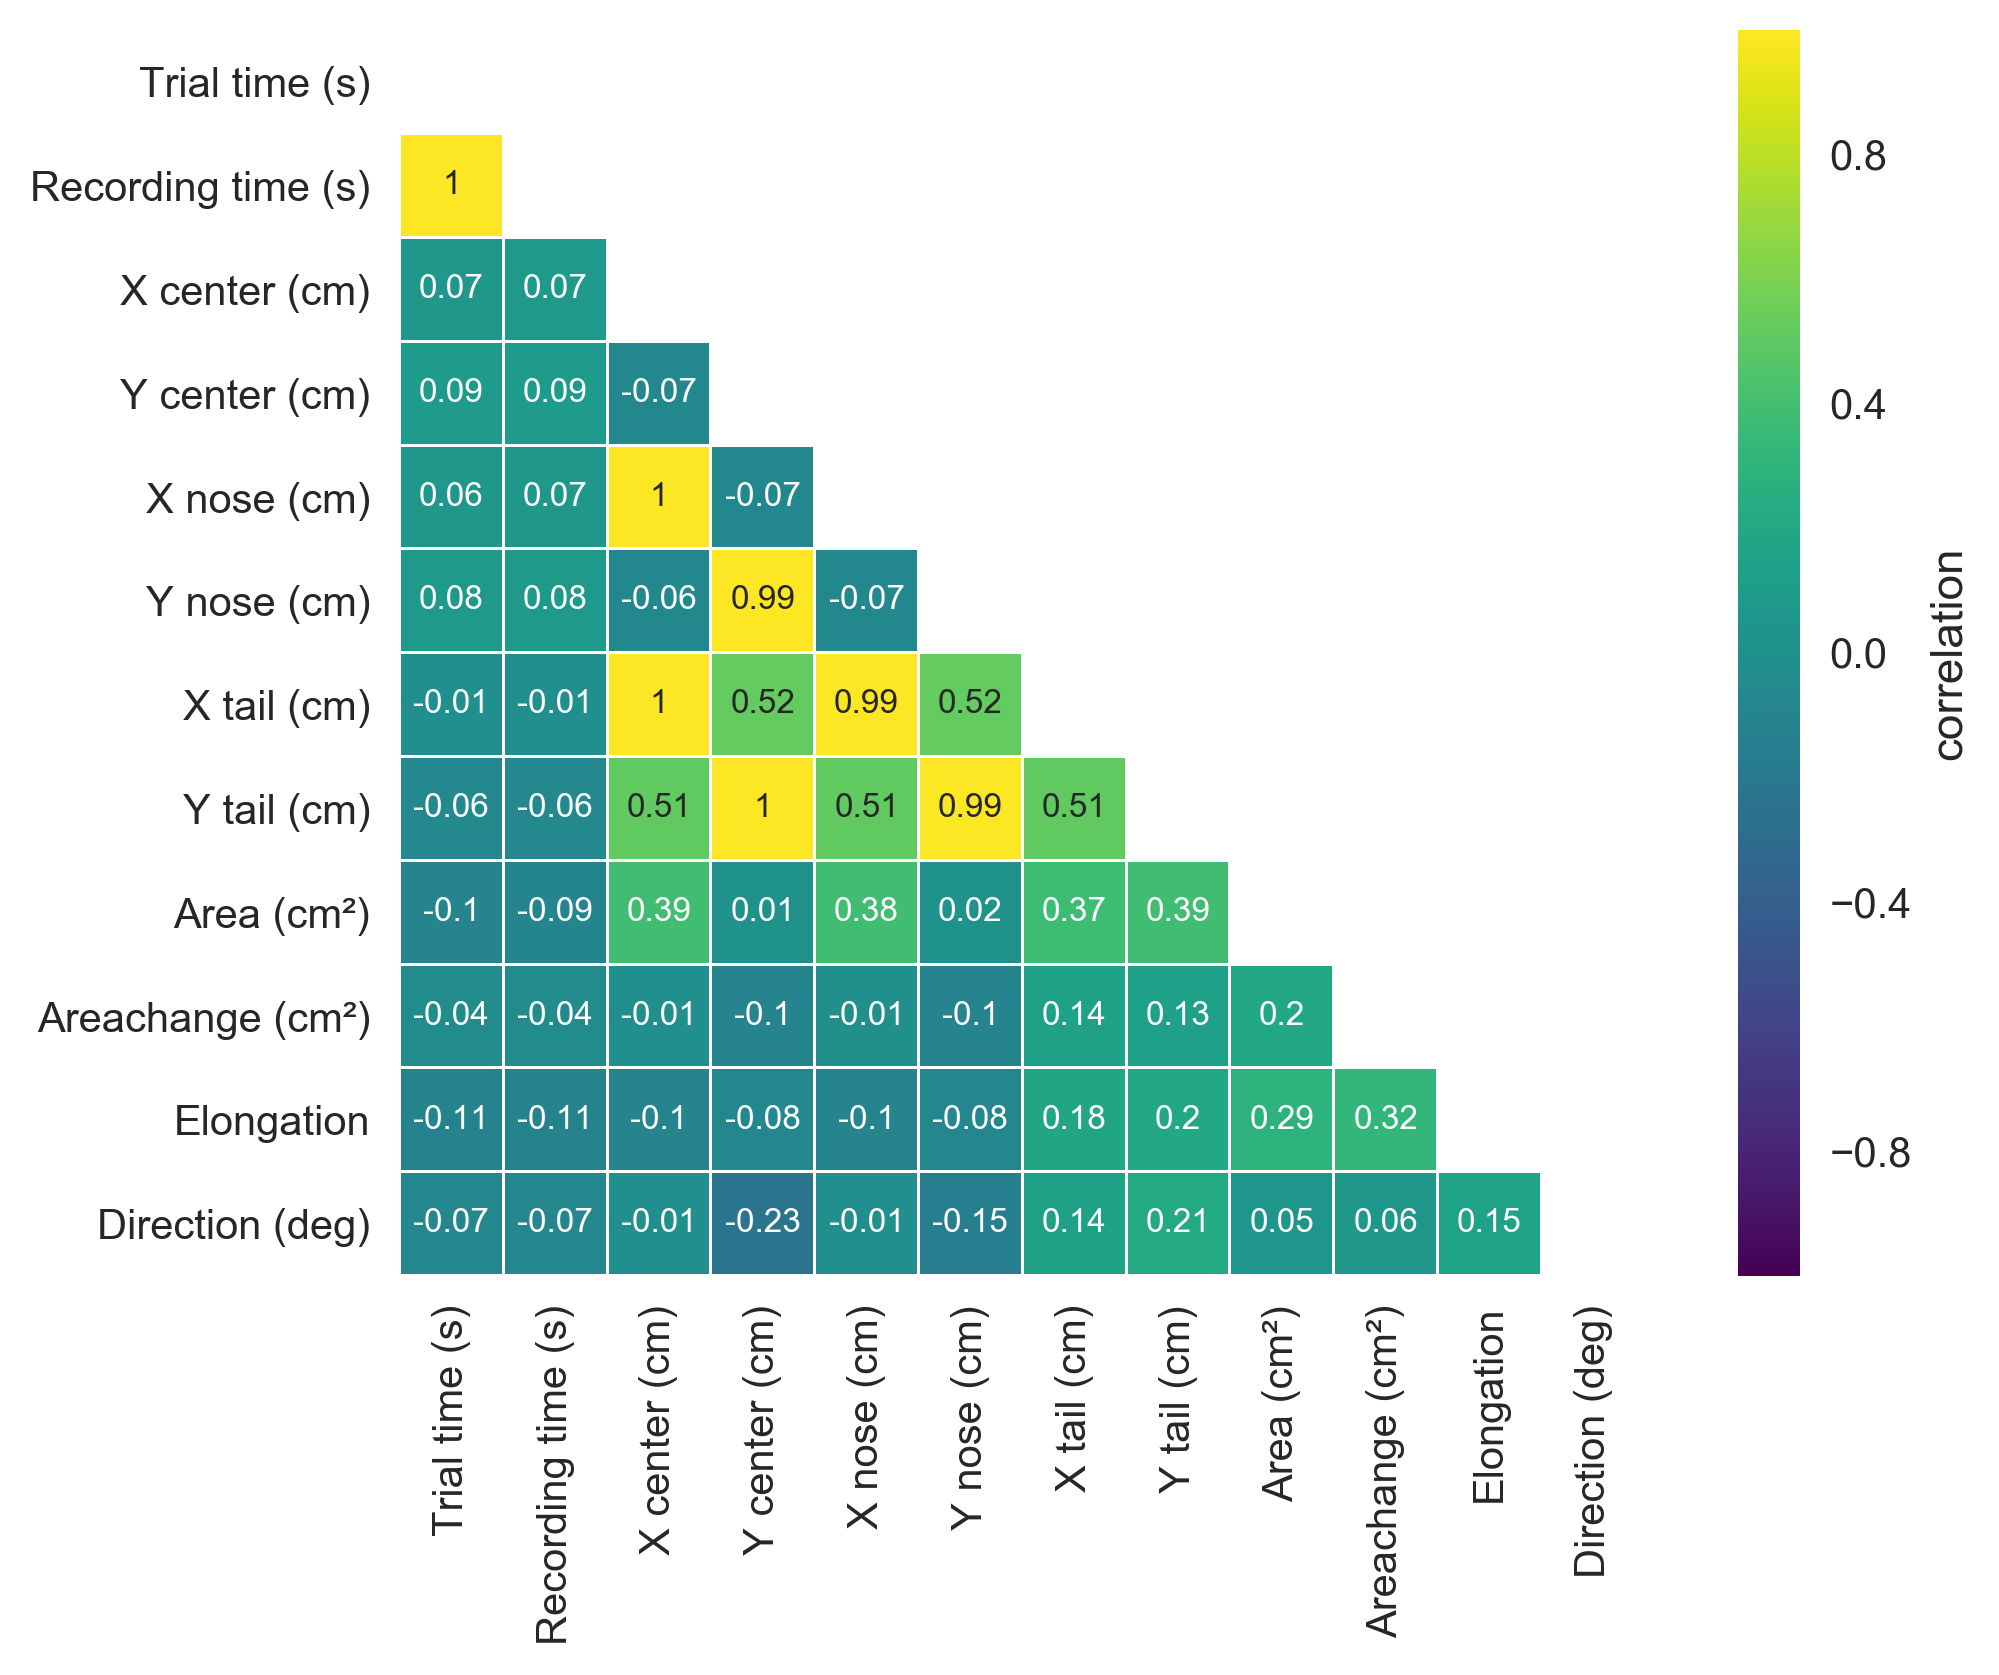

In [7]:
# plot correlation matrix. correlations marked with ^ are not significant (p >= 0.05)
fig, ax = plt.subplots(dpi=300)
r,p,plot = rp_plot(data_long,ax)

In [8]:
# find out which columns correlate less than 0.95 with earlier columns
df = pd.concat(rec.df for rec in data_long)
cols = [col for i,col in enumerate(df.columns) if not any(x > 0.95 for x in np.array(r)[i,:i])]
cols

['Trial time (s)',
 'X center (cm)',
 'Y center (cm)',
 'Area (cm²)',
 'Areachange (cm²)',
 'Elongation',
 'Direction (deg)']

In [9]:
# only keep those columns
data_min = [Recording(fn,df[cols]) for fn,df in data_long]

In [10]:
# only keep data that has less than 25% missing values per column
def missing_data(df):
    return df.isnull().sum().max()/len(df)
data_final = [rec for rec in data_min if missing_data(rec.df) < 0.25]
len(data_final)/len(data)

0.9575163398692811

In [11]:
df = pd.concat(rec.df for rec in data_final)

In [12]:
# size of final data
len(data_final), df.shape

(293, (13185293, 7))

In [13]:
# missing values per column in final data
df.isnull().sum()/len(df)

Trial time (s)      0.000000
X center (cm)       0.005267
Y center (cm)       0.005267
Area (cm²)          0.005267
Areachange (cm²)    0.005428
Elongation          0.005267
Direction (deg)     0.005301
dtype: float64

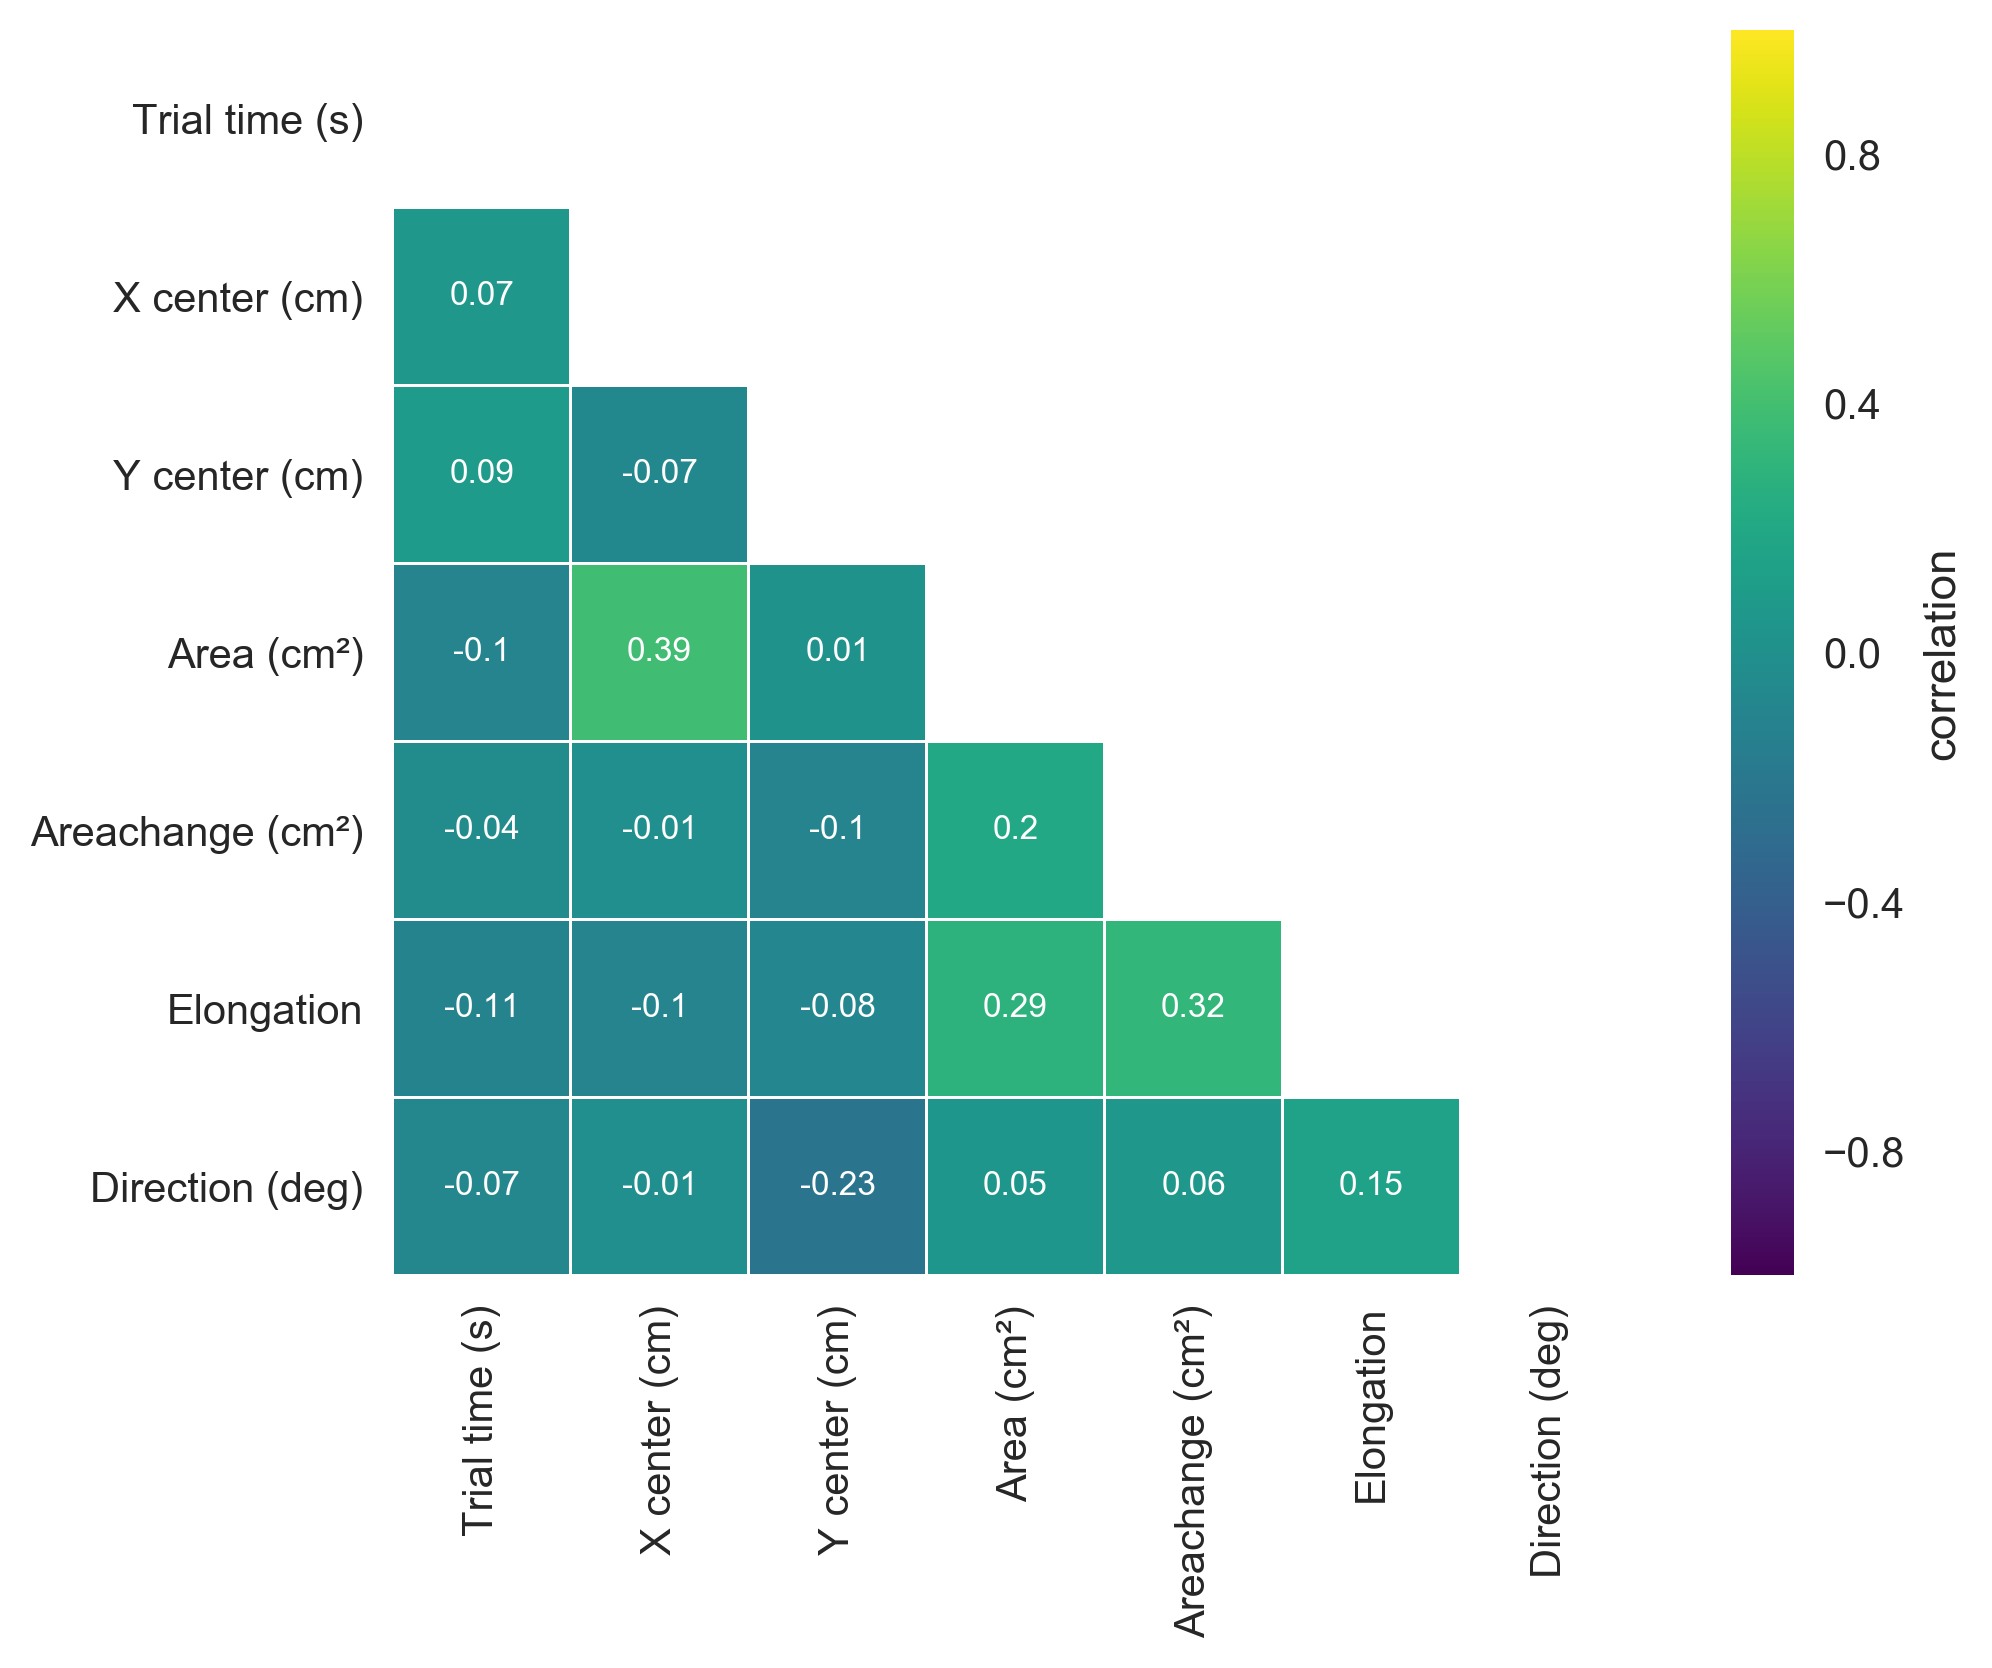

In [14]:
# plot correlation matrix. correlations marked with ^ are not significant (p >= 0.05)
fig, ax = plt.subplots(dpi=300)
r,p,plot = rp_plot(data_final,ax=ax)

In [45]:
def save_data(data,dirpath):
    for fn,df in data:
        df.to_csv(os.path.join(dirpath,fn.replace('_resampled','')),compression='gzip')

In [ ]:
save_data(data_final,'../data_final')

In [ ]:
[rec.fn for rec in data if len(rec.df)!=max(lens)]

In [ ]:
def get_min_max_mean_for_batch(data,batch):
    d = [rec for rec in data if rec.fn.startswith(batch)]
    df = pd.concat(rec.df for rec in d)
    return pd.DataFrame([df.min(),df.max(),df.mean()],index=['min','max','mean']).T

In [ ]:
batches = ['2013','2014','2016','utrecht']
for batch in batches:
    print(batch)
    print(get_min_max_mean_for_batch(data,batch))

In [18]:
x = [rec.df.var(axis=1).mean() for rec in data_long]
y = [rec.df.var(axis=1).mean() for rec in data_min]
np.mean([a/b for a,b in zip(y,x)])

0.82915655264117372

In [16]:
x = [rec.df.cov().mean().mean() for rec in data_long]
y = [rec.df.cov().mean().mean() for rec in data_min]
np.mean([a/b for a,b in zip(y,x)])

0.70372944106025415

In [35]:
x = pd.concat([rec.df for rec in data_long])
v1 = np.nanvar(x)
v1

179572.23519605803

In [36]:
x = pd.concat([rec.df for rec in data_min])
v2 = np.nanvar(x)
v2

137713.2425570593

In [37]:
v2/v1

0.7668960761484267